# Prepare data and libraries
You can copy (drag/drop) the zip to the colab top directory and then unzip it from there.  However, the copy takes a unusually log time.  It is much faster to first copy the zip file to Google Drive and the copy to colab.  We also import libraries and do sanity checks to make sure the python and libraries are compatible.

Get the data file from GitHub.

❗ If you have not been allocated a GPU by Colab, please download the "tiny" dataset (second wget command).

In [ ]:
# If you HAVE been allocated a GPU
!wget https://github.com/efipsom/JGI-Tensorflow/raw/main/data/health_small.zip

--2023-06-02 12:54:50--  https://github.com/efipsom/JGI-Tensorflow/raw/main/data/health_small.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/efipsom/JGI-Tensorflow/main/data/health_small.zip [following]
--2023-06-02 12:54:50--  https://media.githubusercontent.com/media/efipsom/JGI-Tensorflow/main/data/health_small.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530490970 (506M) [application/zip]
Saving to: ‘health_small.zip’

health_small.zip    100%[===================>] 505.92M   370MB/s    in 1.4s    

2023-06-02 12:55:15 (370 MB/s) - ‘health_small.zip’ saved [5304909

In [ ]:
# If you HAVE NOT been allocated a GPU
!wget https://github.com/efipsom/JGI-Tensorflow/raw/main/data/health_tiny.zip

In [ ]:
# Rename file depending on the file you downloaded in previous step
!unzip -q health_small.zip

Now import libraries and check compatabilities.

In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [ ]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")
print(tf.__version__)

2.12.0


(Optional) Define the default font sizes to make the figures prettier:

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Can be very slow without a GPU, check if there's one, or else issue a warning

In [ ]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

## Faster GPUs

<p>Users who have purchased one of Colab's paid plans have access to premium GPUs. You can upgrade your notebook's GPU settings in <code>Runtime &gt; Change runtime type</code> in the menu to enable Premium accelerator. Subject to availability, selecting a premium GPU may grant you access to a V100 or A100 Nvidia GPU.</p>
<p>The free-of-charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.</p>

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is 'Not connected to a GPU', you can change the runtime by going to <code>Runtime &gt; Change runtime type</code> in the menu to enable a GPU accelerator, and then re-execute the code cell.

In [ ]:
# If you have purchased google colab 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jun  2 12:59:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available.
You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is 'Not using a high-RAM runtime', then you can enable a high-RAM runtime via <code>Runtime &gt; Change runtime type</code> in the menu. Then select High-RAM in the Runtime shape drop-down. After, re-execute the code cell.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
print(tf.__version__)

2.12.0


# Custom model
Create a custom CNN model and train on the data.  Evaluate using the validation set to estimate the model's accuracy.

In [ ]:
# Images are originally 600x450
# I think image_dataset_from_directory scales???
batch_size = 32
#img_height = 180
#img_width = 180
#img_height = 360
#img_width = 360
img_height = 224
img_width = 224
#img_height = 450
#img_width = 600
#img_height = 400
#img_width = 400
rseed = 123

num_epochs=30

Rename folder in next line if necessary (if you've downloaded the tiny dataset).

In [ ]:
data_dir = "./health_small/"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  #label_mode='int',
  crop_to_aspect_ratio=True,
  color_mode="rgb",
  subset="training",
  seed=rseed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True)

Found 1923 files belonging to 7 classes.
Using 1539 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  #label_mode='int',
  crop_to_aspect_ratio=True,
  color_mode="rgb",
  subset="validation",
  seed=rseed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True)

Found 1923 files belonging to 7 classes.
Using 384 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


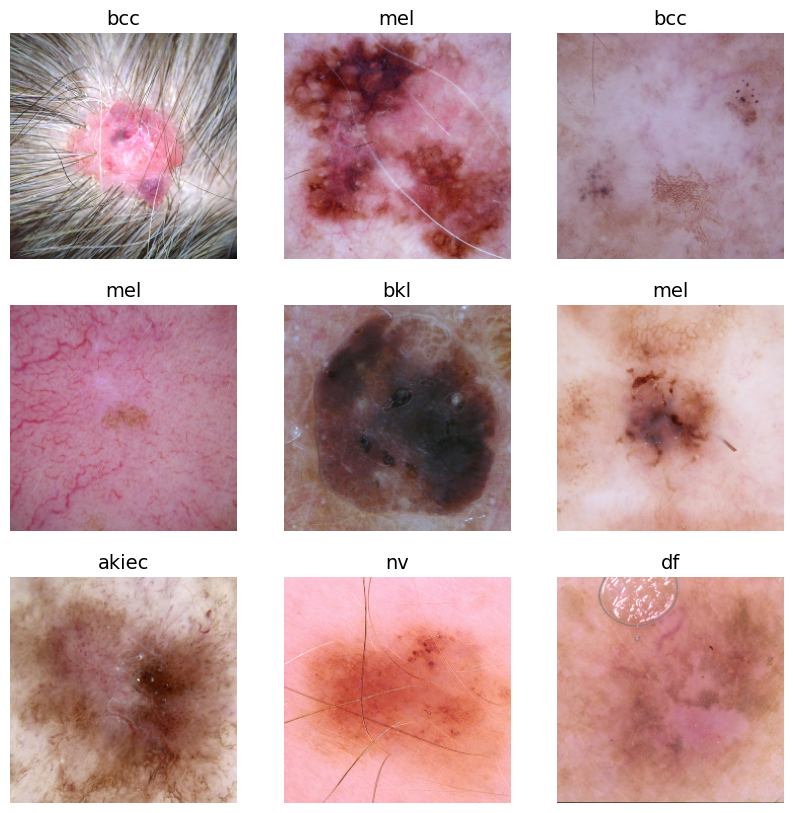

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Given three Conv2d layers (32,64,128 maps) and dense (128,64), kernel_sizes 5,5,3 as does 5,3,3
# tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=(2,2), activation="relu"),
# Given five Conv2d layers, kernel_sizes 5,5,3,3 did ok
# Using strides=(2,2) reduces computational burden as each conv_max pool reduces by four
#   have yet to see a downside, get roughly same accuracy
#   the conv2d+stride is learnable whereas max poolinng is fixed (no params)
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=[img_height, img_width, 3]),
  tf.keras.layers.Conv2D(32, 7, strides=2, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  # Oddly, bad idea
  #tf.keras.layers.Dense(32, activation='relu'),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

In [ ]:
history = model.fit( train_ds, validation_data=val_ds, epochs=num_epochs )

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


49/49 [==============================] - 26s 225ms/step - loss: 1.9388 - accuracy: 0.1676 - val_loss: 1.9265 - val_accuracy: 0.1484
Epoch 2/30
49/49 [==============================] - 1s 26ms/step - loss: 1.9154 - accuracy: 0.1676 - val_loss: 1.9061 - val_accuracy: 0.1484
Epoch 3/30
49/49 [==============================] - 1s 24ms/step - loss: 1.8986 - accuracy: 0.1728 - val_loss: 1.8987 - val_accuracy: 0.1484
Epoch 4/30
49/49 [==============================] - 1s 24ms/step - loss: 1.8983 - accuracy: 0.1858 - val_loss: 1.9038 - val_accuracy: 0.1484
Epoch 5/30
49/49 [==============================] - 1s 24ms/step - loss: 1.8932 - accuracy: 0.1689 - val_loss: 1.8988 - val_accuracy: 0.1484
Epoch 6/30
49/49 [==============================] - 1s 24ms/step - loss: 1.8875 - accuracy: 0.1793 - val_loss: 1.8977 - val_accuracy: 0.1484
Epoch 7/30
49/49 [==============================] - 1s 24ms/step - loss: 1.8909 - accuracy: 0.1884 - val_loss: 1.8934 - val_accuracy: 0.1484
Epoch 8/30
49/49 [====

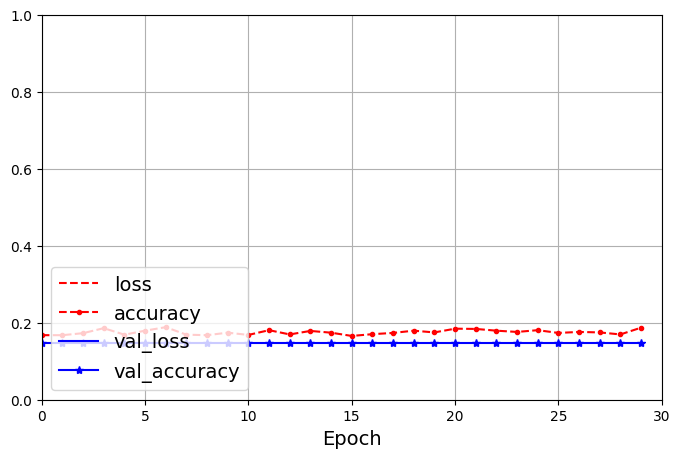

In [ ]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
#save_fig("keras_learning_curves_plot")  # extra code
plt.show()

## Discussions: 
* What is your observation on accuracy and no. of epochs?
* What change can be made to improve accuracy?

# Residual CNN
Create a well known resnet model and train/evaluate.

In [ ]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[img_height, img_width, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualLayer(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

In [ ]:
# compiles and provide model summary
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_layer (ResidualLay  (None, 56, 56, 64)       74240     
 er)                                                             
                                                      

In [ ]:
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

Epoch 1/30
49/49 [==============================] - 42s 213ms/step - loss: 2.0809 - accuracy: 0.3307 - val_loss: 729.5757 - val_accuracy: 0.1875
Epoch 2/30
49/49 [==============================] - 9s 187ms/step - loss: 1.5526 - accuracy: 0.4087 - val_loss: 60.6895 - val_accuracy: 0.1849
Epoch 3/30
49/49 [==============================] - 9s 188ms/step - loss: 1.5088 - accuracy: 0.4386 - val_loss: 13.0297 - val_accuracy: 0.1458
Epoch 4/30
49/49 [==============================] - 9s 189ms/step - loss: 1.3981 - accuracy: 0.4691 - val_loss: 8.3890 - val_accuracy: 0.1901
Epoch 5/30
49/49 [==============================] - 9s 189ms/step - loss: 1.3751 - accuracy: 0.4873 - val_loss: 3.6179 - val_accuracy: 0.3542
Epoch 6/30
49/49 [==============================] - 9s 191ms/step - loss: 1.2991 - accuracy: 0.5101 - val_loss: 3.0385 - val_accuracy: 0.3255
Epoch 7/30
49/49 [==============================] - 9s 192ms/step - loss: 1.2679 - accuracy: 0.5172 - val_loss: 1.7190 - val_accuracy: 0.4427
E

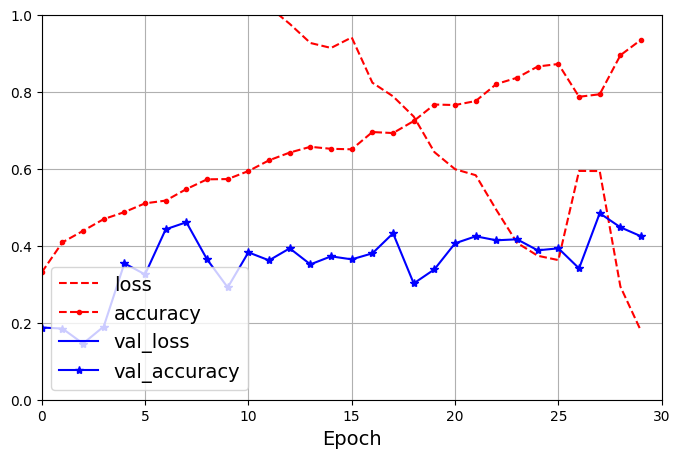

In [ ]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
#save_fig("keras_learning_curves_plot")  # extra code
plt.show()

## Disucssions: 
* What is your observation on accuracy/loss with no. of epoches? 
* Should we increase the number of epochs? 

# Transfer Learning
We use existing model architecture and its pre-trained weights.  The base model was trained on the ImageNet dataset that has 1000 classes (the top layer uses a softmax to classify from the one thousand categories).  We only have 7 classes so will only need the model/weights for the representation learning part of the base model and exclude the top layer.  We will than add our top layer for the seven classes.  Then we will then unfreeze all the layers of the base model (i.e. make trainable). Finally, we train new model on our data.

In [ ]:
#num_classes=7
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
#base_model = tf.keras.applications.resnet_v2.ResNet50V2(weights="imagenet", include_top=False)
#base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False)
#base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(weights="imagenet", include_top=False)
#base_model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(num_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
# After changing trainnable need to compile
for layer in base_model.layers:
    layer.trainable = True

# compiles and provide model summary ""
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

In [ ]:
# fits, evaluates, and uses the model to make predictions
num_epochs=20
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

Epoch 1/20
49/49 [==============================] - 79s 597ms/step - loss: 1.2168 - accuracy: 0.5556 - val_loss: 6.3573 - val_accuracy: 0.0964
Epoch 2/20
49/49 [==============================] - 27s 549ms/step - loss: 0.6157 - accuracy: 0.7830 - val_loss: 8.5731 - val_accuracy: 0.1432
Epoch 3/20
49/49 [==============================] - 26s 530ms/step - loss: 0.3435 - accuracy: 0.8778 - val_loss: 2.7762 - val_accuracy: 0.5365
Epoch 4/20
49/49 [==============================] - 27s 545ms/step - loss: 0.3520 - accuracy: 0.8895 - val_loss: 2.3139 - val_accuracy: 0.4635
Epoch 5/20
49/49 [==============================] - 26s 534ms/step - loss: 0.2293 - accuracy: 0.9240 - val_loss: 1.6793 - val_accuracy: 0.6198
Epoch 6/20
49/49 [==============================] - 26s 524ms/step - loss: 0.1475 - accuracy: 0.9474 - val_loss: 1.6917 - val_accuracy: 0.6693
Epoch 7/20
49/49 [==============================] - 26s 525ms/step - loss: 0.1136 - accuracy: 0.9584 - val_loss: 2.2346 - val_accuracy: 0.5755

## Discussions: 
* How do you think transfer learning helped with this task? 

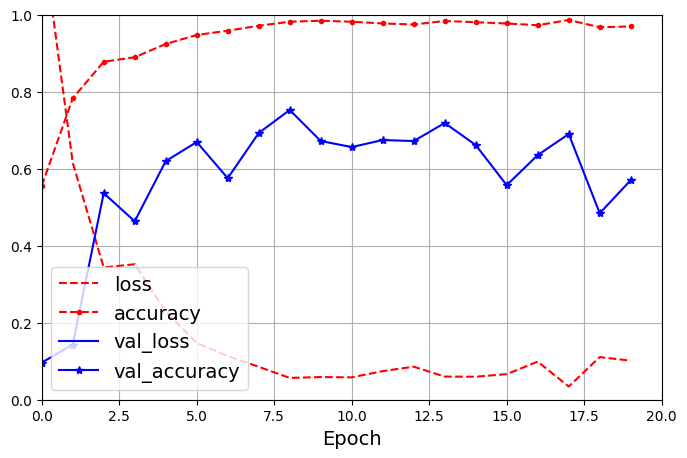

In [ ]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
#save_fig("keras_learning_curves_plot")  # extra code
plt.show()

# Save the model

## Save the model to use later for predicting the type of mole/skin images.

In [ ]:
#=====================================================#
# Save model
#=====================================================#
model.save("skin_cancer_xception_model", save_format="h5")

## Reading and using saved model
This is an example of reading back in just the model and using.  You will still need to import libraries, etc.

In [ ]:
#=====================================================#
# Sometime later, restore model
#=====================================================#
# extra code – show the contents of the my_keras_model/ directory
#for path in sorted(Path("skin_cancer_xception_model").glob("**/*")):
#    print(path)
model = tf.keras.models.load_model("skin_cancer_xception_model")
#evaluate_model(model)
# fits, evaluates, and uses the model to make predictions
num_epochs=30
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

Epoch 1/30
49/49 [==============================] - 59s 510ms/step - loss: 0.0897 - accuracy: 0.9727 - val_loss: 1.8548 - val_accuracy: 0.6380
Epoch 2/30
49/49 [==============================] - 25s 508ms/step - loss: 0.0881 - accuracy: 0.9688 - val_loss: 2.0035 - val_accuracy: 0.6745
Epoch 3/30
49/49 [==============================] - 27s 544ms/step - loss: 0.0620 - accuracy: 0.9818 - val_loss: 1.5747 - val_accuracy: 0.6406
Epoch 4/30
49/49 [==============================] - 26s 527ms/step - loss: 0.0582 - accuracy: 0.9818 - val_loss: 1.8849 - val_accuracy: 0.6198
Epoch 5/30
49/49 [==============================] - 26s 521ms/step - loss: 0.0163 - accuracy: 0.9961 - val_loss: 1.1010 - val_accuracy: 0.7474
Epoch 6/30
49/49 [==============================] - 26s 532ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 1.1435 - val_accuracy: 0.7500
Epoch 7/30
49/49 [==============================] - 26s 522ms/step - loss: 0.0012 - accuracy: 0.9994 - val_loss: 1.3420 - val_accuracy: 0.7630

In [ ]:
def show_history(history, num_epochs):
    pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
        style=["r--", "r--.", "b-", "b-*"])
    plt.legend(loc="lower left")  # extra code
    #save_fig("keras_learning_curves_plot")  # extra code
    plt.show()

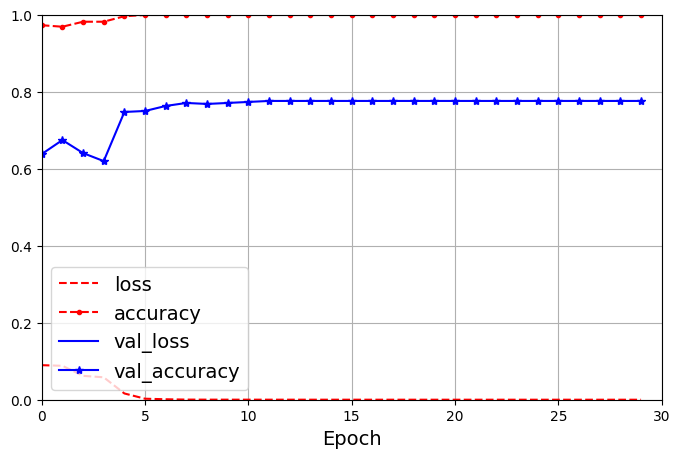

In [ ]:
show_history(history, num_epochs)